### Specific Test II. Lens Finding (Method - Self-Attention CNNs)

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1eXmbZqUfpqhI-MWz2xkpK0dXQ4FttGQf/view?usp=sharing

**Dataset Description:** A data set comprising images with and without strong lenses. gmentation methods to improve your results.

<img src="samples.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="900"/>

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: We create a model which combines CNNs and an attention mechanism to handle a multimodal input consisting of images and features.

Here are the steps in detail: 
*   For the image branch, we have two Conv2D and a MaxPooling2D laayer to extract features from the image.
*   Then we can processes the input features from the csv fle using a branch with a dense layer and concatenate it with the image branch.
*   Next, a custom self-attention layer is applied to the combined output in which the attention mechanism computes attention weights for the concatenated features, allowing the model to focus on the most important parts of the image and non-image features. The weighted sum of these features is then computed.
*   Finally, the output of the attention layer is passed through two Dense layers, with the final layer using a sigmoid activation function to output a probability.


**Results:** AUC on validation set is 0.99

<img src="lens_finding_results.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="700"/>


In [ ]:
!pip install keras astropy --user
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras import layers, models, Model, Input

from keras.metrics import Accuracy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Concatenate, Softmax, Reshape, Add, Activation

import keras
import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

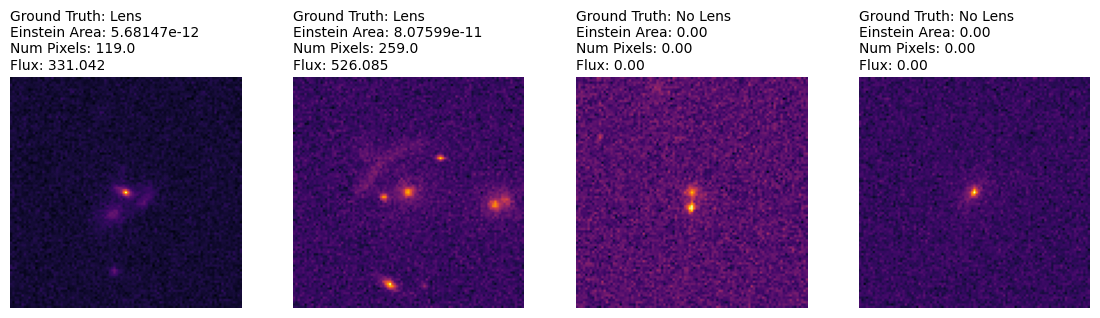

In [239]:
def plot_images(df, fits_directory, batch_size=4):
    # Randomly select 4 images from the dataframe
    random_indices = random.sample(range(len(df)), batch_size)
    random_images_df = df.iloc[random_indices]
    images = []
    features = []
    image_labels = []

    for index, row in random_images_df.iterrows():
        # Load FITS image
        file_name = f"{directory}/imageEUC_VIS-{int(row['ID'])}.fits"
        image_data = fits.getdata(file_name)
        images.append(image_data)
        # Extract additional features
        feature_vector = [row['Einstein_area'], row['numb_pix_lensed_image'], row['flux_lensed_image_in_sigma']]
        features.append(feature_vector)
        # Get the ground truth
        image_labels.append(row['is_lens'])
    images = np.array(images)
    features = np.array(features)
    image_labels = np.array(image_labels)

    # Separate images and features by label
    label_0_images = images[np.where(image_labels == 0)]
    label_1_images = images[np.where(image_labels == 1)]
    label_0_features = features[np.where(image_labels == 0)]
    label_1_features = features[np.where(image_labels == 1)]
    # Retry if not enough images
    while len(label_0_images) < 2 or len(label_1_images) < 2:
        plot_images(df, fits_directory, batch_size)
        return
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    for i in range(2):
        axes[i].imshow(label_1_images[i].squeeze(), cmap='inferno')
        title = f'Ground Truth: Lens\nEinstein Area: {label_1_features[i][0]:}\nNum Pixels: {label_1_features[i][1]:}\nFlux: {label_1_features[i][2]:}'
        text_obj = axes[i].set_title(title, fontsize=10, ha='left')
        text_obj.set_position((-0.0, 1.0)) 
        axes[i].axis('off')

        axes[i+2].imshow(label_0_images[i].squeeze(), cmap='inferno')
        title = f'Ground Truth: No Lens\nEinstein Area: {label_0_features[i][0]:.2f}\nNum Pixels: {label_0_features[i][1]:.2f}\nFlux: {label_0_features[i][2]:.2f}'
        text_obj = axes[i+2].set_title(title, fontsize=10,ha='left')
        text_obj.set_position((-0.0, 1.0)) 
        axes[i+2].axis('off')
    plt.show()

directory = 'SpaceBasedTraining/files'
csv_file = "SpaceBasedTraining/classifications.csv"

df = pd.read_csv(csv_file)
# Plot the images
plot_images(df, directory)


In [3]:
hdul = fits.open('SpaceBasedTraining/files/imageEUC_VIS-100000.fits')
hdul.info()
def data_generator(df, fits_directory, batch_size):  
    while True:
        # Shuffle the dataframe
        df = df.sample(frac=1).reset_index(drop=True)

        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]

            # Load the FITS images and extract the additional features
            images = []
            features = []
            labels = []

            for index, row in batch_df.iterrows():
                # Load FITS image
                file_name = f"{fits_directory}/imageEUC_VIS-{int(row['ID'])}.fits"
                image_data = fits.getdata(file_name)
                images.append(image_data)

                # Extract additional features
                feature_vector = [row['Einstein_area'], row['numb_pix_lensed_image'], row['flux_lensed_image_in_sigma']]
                features.append(feature_vector)

                # Get the ground truth
                labels.append(row['is_lens'])

            # Convert lists to numpy arrays
            images = np.array(images)
            features = np.array(features)
            labels = np.array(labels)

            yield [images, features], labels


In [4]:
from sklearn.model_selection import train_test_split

def split_data(csv_file, validation_split=0.1, random_state=42):
    df = pd.read_csv(csv_file)
    train_df, val_df = train_test_split(df, test_size=validation_split, random_state=random_state, stratify=df['is_lens'])
    return train_df, val_df

fits_directory  = 'SpaceBasedTraining/files'
csv_file = "SpaceBasedTraining/classifications.csv"

batch_size = 128

train_df, val_df = split_data(csv_file)
train_generator = data_generator(train_df, fits_directory, batch_size)
validation_generator = data_generator(val_df, fits_directory, batch_size)


steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

In [8]:
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.nn.tanh(tf.linalg.matmul(inputs, self.W))
        a = tf.nn.softmax(q, axis=1)
        weighted_sum = tf.reduce_sum(inputs * a, axis=1)
        return tf.expand_dims(weighted_sum, axis=-1)

In [9]:
def image_branch(input_image):
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Dense(64, activation='relu')(x)

def feature_branch(input_features):
    x = Dense(32, activation='relu')(input_features)
    return x

def cnn_with_attention():
    # Image input branch
    input_image = Input(shape=(101, 101, 1))
    image_output = image_branch(input_image)

    # Additional features input branch
    input_features = Input(shape=(3,))
    feature_output = feature_branch(input_features)

    # Concatenate the branches
    combined = Concatenate()([image_output, feature_output])
    
    # Attention mechanism
    attention = AttentionLayer()(combined)

    # Final layers
    x = Dense(64, activation='relu')(attention)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[input_image, input_features], outputs=output)

    return model

In [15]:
model = cnn_with_attention()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
checkpoint = ModelCheckpoint("spacedbasedTraining_checkpoint.h5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')

In [16]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=validation_generator, validation_steps=validation_steps, callbacks = [checkpoint])

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.1805 - auc: 0.9872
Epoch 1: val_auc improved from -inf to 0.98559, saving model to spacedbasedTraining_checkpoint.h5
126/126 [==============================] - 84s 662ms/step - loss: 0.1805 - auc: 0.9872 - val_loss: 0.1336 - val_auc: 0.9856
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.1015 - auc: 0.9865
Epoch 2: val_auc improved from 0.98559 to 0.98560, saving model to spacedbasedTraining_checkpoint.h5
126/126 [==============================] - 43s 340ms/step - loss: 0.1015 - auc: 0.9865 - val_loss: 0.0861 - val_auc: 0.9856
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0729 - auc: 0.9879
Epoch 3: val_auc improved from 0.98560 to 0.98561, saving model to spacedbasedTraining_checkpoint.h5
126/126 [==============================] - 41s 329ms/step - loss: 0.0729 - auc: 0.9879 - val_loss: 0.0783 - val_auc: 0.9856
Epoch 4/20
126/126 [==============================] - E

In [99]:
# Load the FITS images and extract the additional features
images = []
features = []
labels = []

for index, row in val_df.iterrows():
    # Load FITS image
    file_name = f"{fits_directory}/imageEUC_VIS-{int(row['ID'])}.fits"
    image_data = fits.getdata(file_name)
    images.append(np.expand_dims(image_data, axis=-1))  # Add channel dimension

    # Extract additional features
    feature_vector = [row['Einstein_area'], row['numb_pix_lensed_image'], row['flux_lensed_image_in_sigma']]
    features.append(feature_vector)

    # Get the ground truth
    labels.append(row['is_lens'])
# Convert lists to numpy arrays
images = np.array(images)
features = np.array(features)
labels = np.array(labels)

57/57 [==============================] - 0s 3ms/step


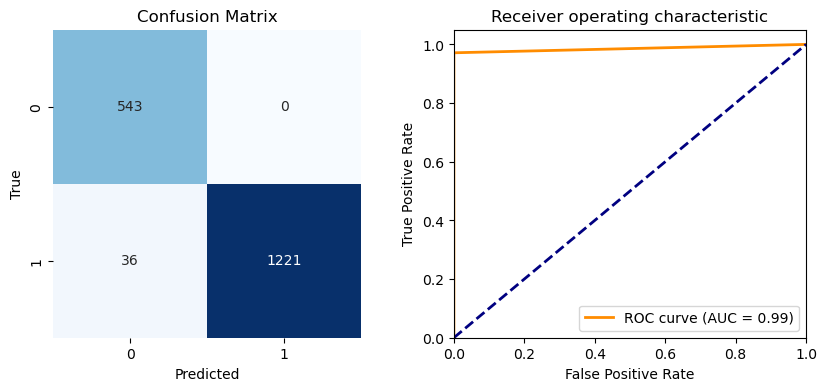

In [101]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = val_df['is_lens'].values
y_pred = (model.predict([images, features]) > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_true, y_pred)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix')

# Plot the ROC curve
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver operating characteristic')
axs[1].legend(loc="lower right")

plt.show()
